
0: 384x512 1 person, 120.5ms
Speed: 3.0ms preprocess, 120.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)


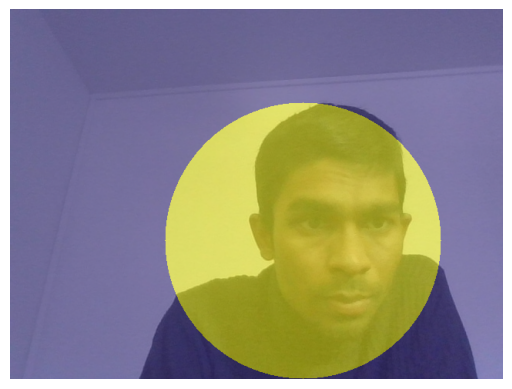


0: 384x512 1 person, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)


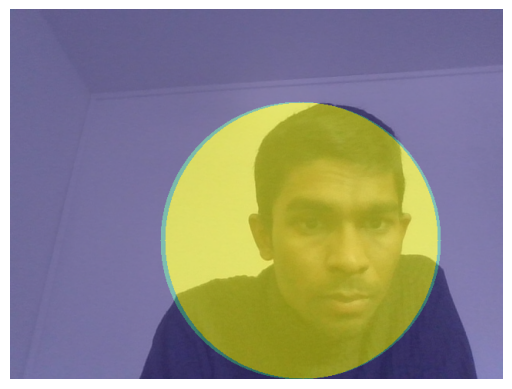


0: 384x512 1 person, 134.1ms
Speed: 2.0ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)


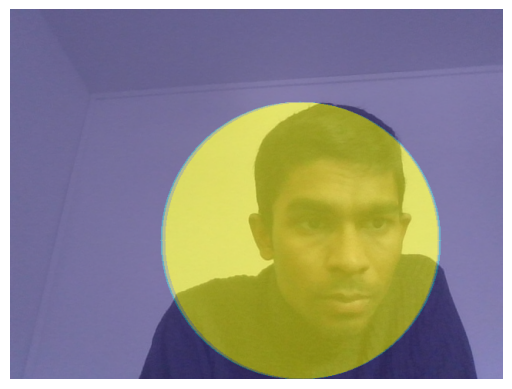


0: 384x512 1 person, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 512)


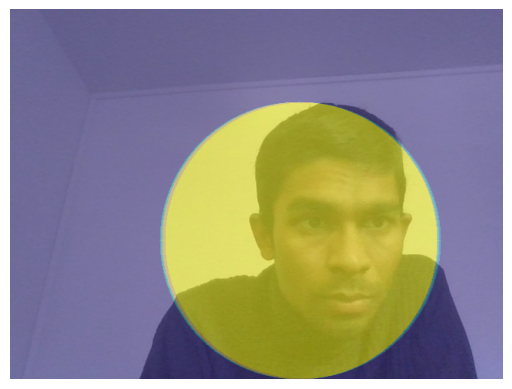

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from main_utils import *
#from utils import create_detection_table


MODEL = "best.pt"
model = YOLO(MODEL)

cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
heatmap_obj = heatmap.Heatmap()
heatmap_obj.set_args(colormap=cv2.COLORMAP_PARULA, imw=frame_width, imh=frame_height, shape="circle")

detections = []
count = 0
track_history = defaultdict(lambda: [])

conn = sqlite3.connect('detection_database.db')
cursor = conn.cursor()

# Create detection table if it does not exit
create_detection_table(cursor)

# Function to update the Matplotlib plot with new frames
def update_plot(frame):
    plt.clf()
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.pause(0.1)

plt.ion()  # Turn on interactive mode for Matplotlib
#[{'time': '2024-02-23 14:20:37', 'xyxy': [[28.64773178100586, 134.34608459472656, 640.0, 479.8232727050781]], 'confidence': [0.893378496170044], 'class_id': [0], 'object_id': [1]}]
try:
    while cap.isOpened():
        success, image = cap.read()
        if success:
            results = model.track(image, persist=True, tracker="bytetrack.yaml")
            heatmap_frame = heatmap_obj.generate_heatmap(image.copy(), results)
            update_plot(heatmap_frame)
            if results[0].boxes.id is not None:
                detections = [{'time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                               'xyxy': list(results[0].boxes.xyxy.cpu().tolist()),
                               'confidence': list(results[0].boxes.conf.cpu().tolist()),
                               'class_id': list(results[0].boxes.cls.cpu().int().tolist()),
                               'object_id': list(map(int, list(results[0].boxes.id.cpu().tolist())))}]
                frame = results[0].plot()
                annotated_frame = plot_tracks(frame, results, track_history)
                try:
                    insert_detection(cursor, detections)
                    conn.commit()  # Commit the transaction
                except Exception as e:
                    print("Error inserting data into database:", e)
                    conn.rollback()  # Rollback the transaction in case of an error
            else:
                annotated_frame = None

            if annotated_frame is not None and annotated_frame.size > 0:
              
                # update_plot(annotated_frame)
                pass
            else:
              pass
                # update_plot(image)

            plt.pause(0.5)

        else:
            break

except KeyboardInterrupt:
    pass
  

cap.release()
cv2.destroyAllWindows()
